# Prophet Changepoint Test

Looking to see how well prophet detects a changepoint in the data and how it performs. Using boht its automatic detection and giving changepoint manually

## Dependencies

In [56]:
# essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools 
from utils import create_session, mape

from statsmodels.tsa.seasonal import STL


# model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot


# Snowflake
from snowflake.snowpark import Session

## Preparing data
Not removing outliers because it changes the post changepoint data too much.

In [21]:
session = create_session()

df = session.table("company_revenue_time_series_2") # without cutoff
df = df.to_pandas()

df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

print(df.head())
print('-'*60)
print(df.info())

# train / test split
cutoff = round(len(df) * 0.8)

train_80 = df[:cutoff]
test_80 = df[cutoff:]

cutoff = round(len(df) * 0.9)

train_90 = df[:cutoff]
test_90 = df[cutoff:]

          ds          y
0 2012-03-02  137233.99
1 2012-03-03  190247.55
2 2012-03-04  197809.12
3 2012-03-05  125417.64
4 2012-03-06  120953.92
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      514 non-null    datetime64[ns]
 1   y       514 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.2 KB
None


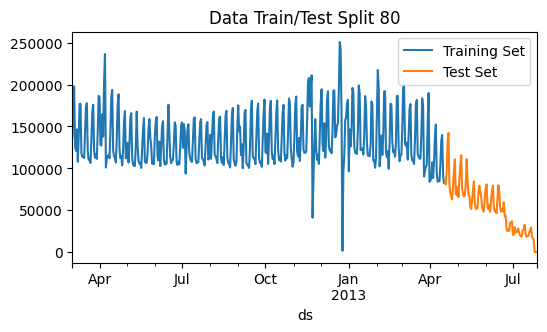

In [22]:
fig, ax = plt.subplots(figsize=(6, 3))
train_80.plot(x='ds', ax=ax, label='Training Set', title='Data Train/Test Split 80')
test_80.plot(x='ds', ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])

plt.show()

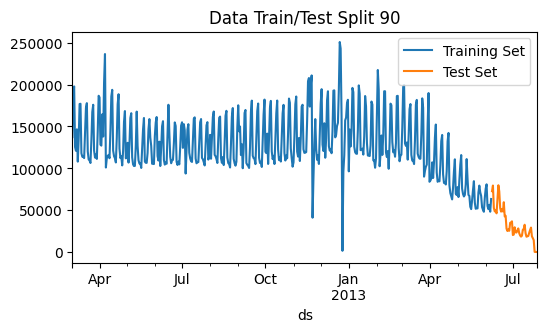

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
train_90.plot(x='ds', ax=ax, label='Training Set', title='Data Train/Test Split 90')
test_90.plot(x='ds', ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])


plt.show()

## Fitting the model

#### Setting up test function

In [62]:
def test_model(model, test):

    forecast = model.predict(test)

    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)


    total_mape = mape(test['y'], forecast['yhat'])
    print(f'Total MAPE: {total_mape}%')

#### Automatic changepoint detection

11:00:34 - cmdstanpy - INFO - Chain [1] start processing
11:00:34 - cmdstanpy - INFO - Chain [1] done processing


Total MAPE: 10471.01%


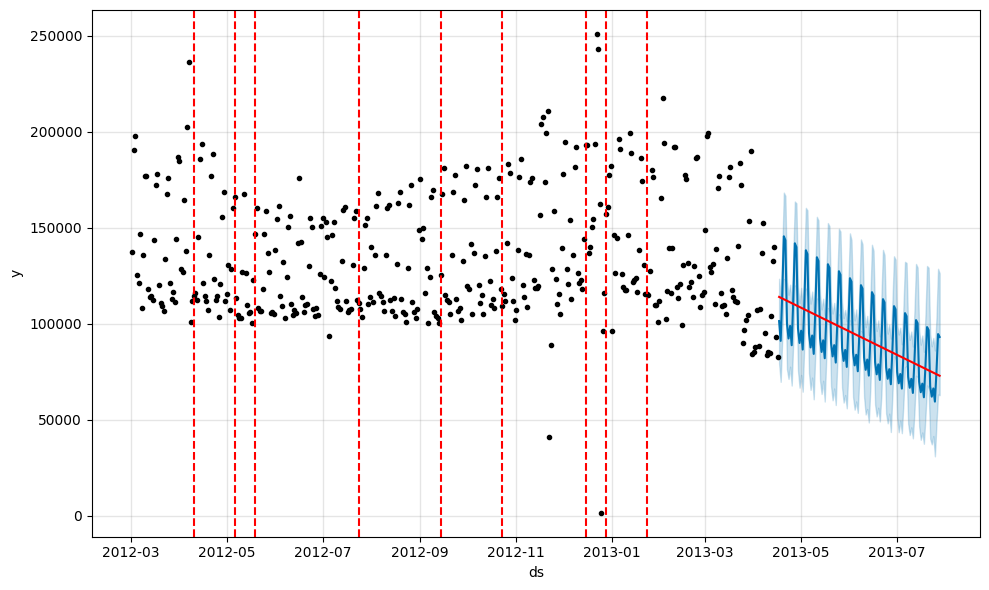

In [67]:
model = Prophet(
    growth = 'linear', 
    weekly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,

)
model.fit(train_80)

test_model(model, test_80)

11:00:39 - cmdstanpy - INFO - Chain [1] start processing
11:00:39 - cmdstanpy - INFO - Chain [1] done processing


Total MAPE: 342.83%


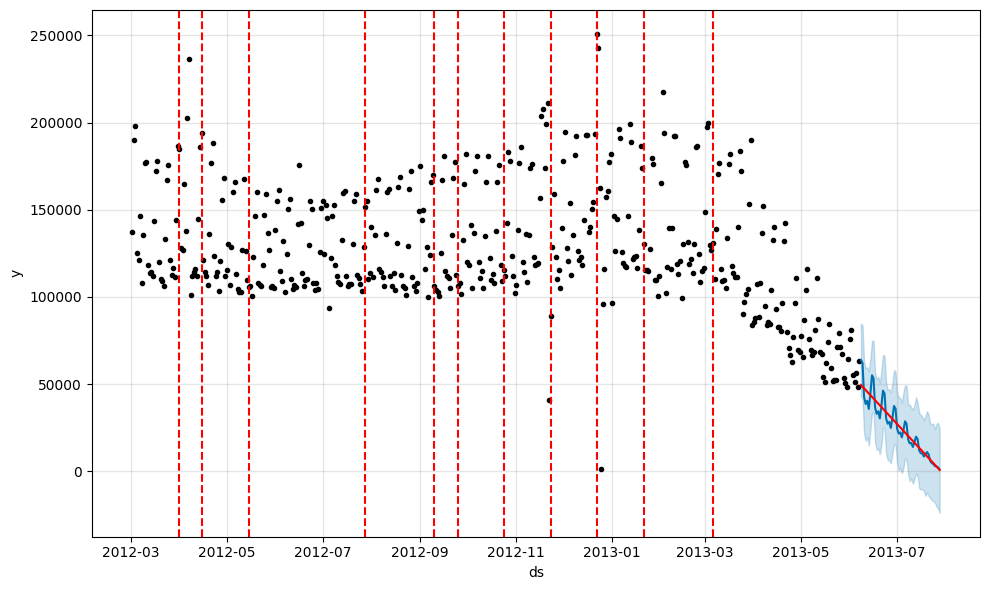

In [68]:
model = Prophet(
    growth = 'linear', 
    weekly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,

)
model.fit(train_90)

test_model(model, test_90)

#### Manual changepoint

11:00:48 - cmdstanpy - INFO - Chain [1] start processing
11:00:48 - cmdstanpy - INFO - Chain [1] done processing


Total MAPE: 2880.7%


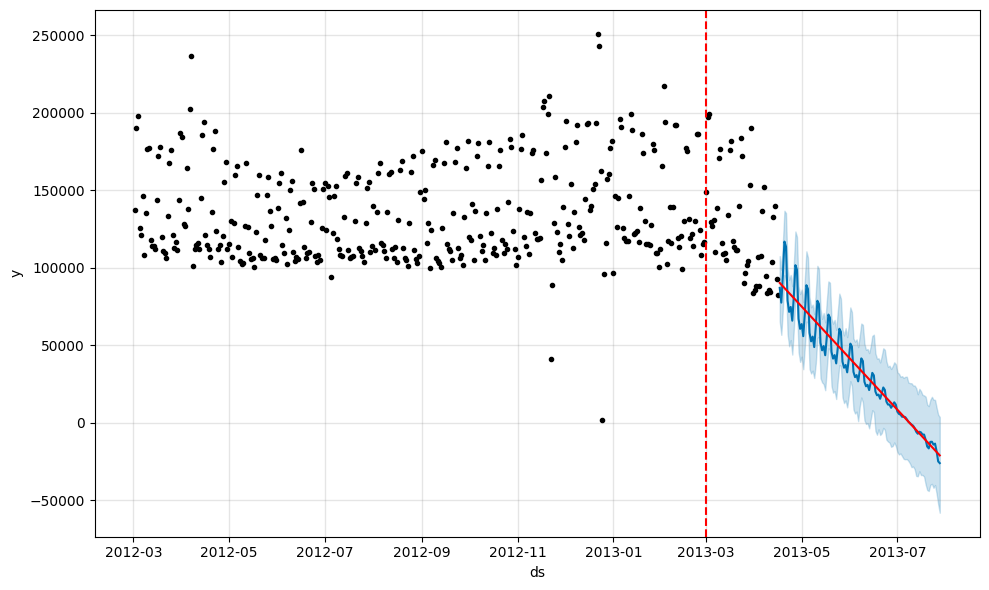

In [69]:
model = Prophet(
    growth = 'linear', 
    changepoints = ['2013-03-01'],
    weekly_seasonality = True,
    yearly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,
)
model.fit(train_80)

test_model(model, test_80)

11:00:54 - cmdstanpy - INFO - Chain [1] start processing
11:00:54 - cmdstanpy - INFO - Chain [1] done processing


Total MAPE: 3888.08%


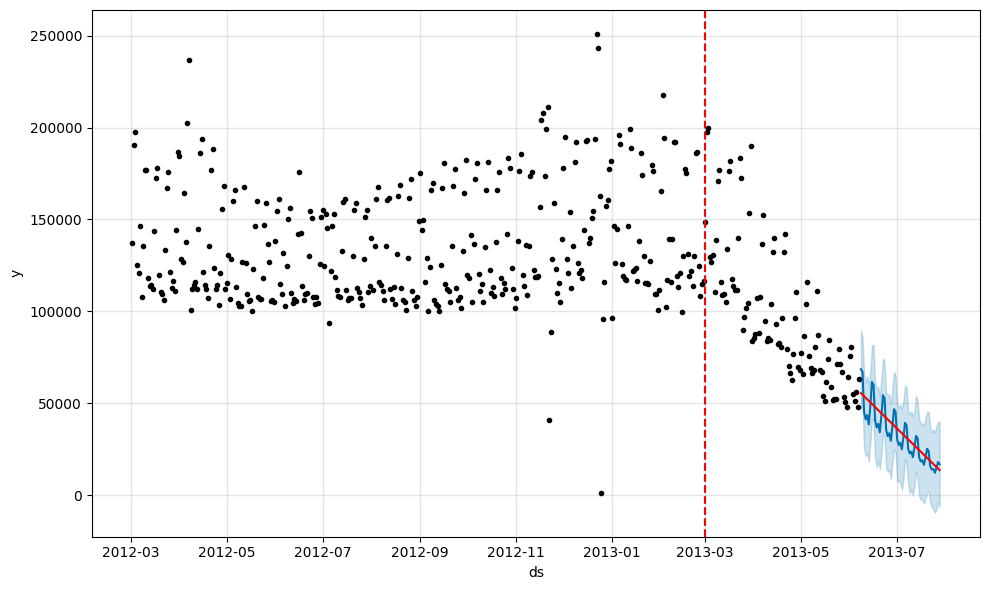

In [71]:
model = Prophet(
    growth = 'linear', 
    changepoints = ['2013-03-01'],
    weekly_seasonality = True,
    yearly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,
)
model.fit(train_90)

test_model(model, test_90)

#### Cross validation

In [45]:
manual_model = Prophet(
    growth = 'linear', 
    changepoints = ['2013-03-01'],
    weekly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,
)

manual_model.fit(df)

auto_model = Prophet(
    growth = 'linear', 
    weekly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,
)

auto_model.fit(df)

10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
def cross_validation_test(model):
    df_cv = cross_validation(model, 
                            initial='365 days',  # Training set size
                            period='30 days',    # Cutoff frequency
                            horizon='50 days')   # Forecast horizon

    df_performance = performance_metrics(df_cv)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(df['ds'], df['y'], label='Actual', color='blue', alpha=0.5)
    plt.scatter(df_cv['ds'], df_cv['yhat'], label='Predicted', color='orange', s=10)

    # Formatting the plot
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

    print(df_performance)

    actual_values = df_cv['y']
    predicted_values = df_cv['yhat']

    # Calculate total MAPE
    total_mape = mape(actual_values, predicted_values)
    print(f'Total MAPE: {total_mape}%')


This is the Automatic model cross validation results: 



  0%|          | 0/4 [00:00<?, ?it/s]10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  9.32it/s]10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:00<00:00, 11.87it/s]10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:00<00:00, 10.42it/s]


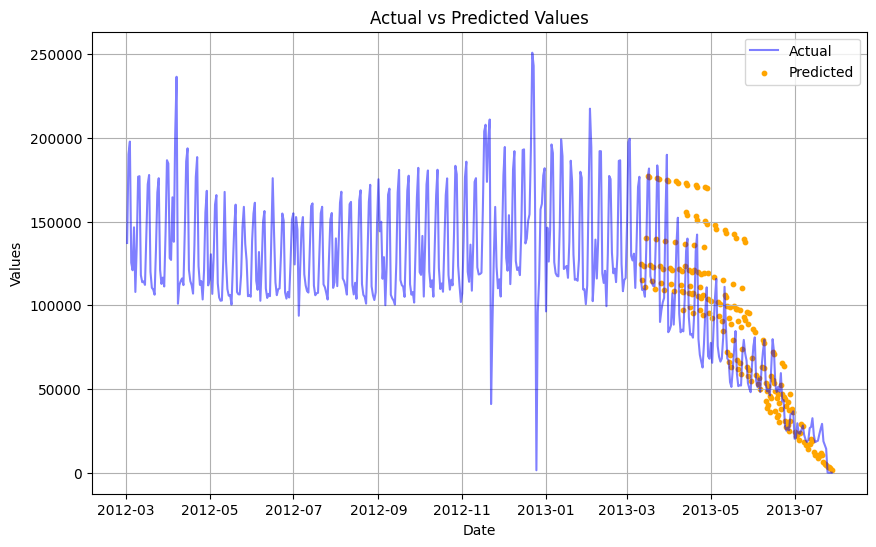

   horizon           mse          rmse           mae       mape     mdape  \
0   5 days  1.606637e+08  12675.317637  10983.084515   0.130165  0.140547   
1   6 days  1.560363e+08  12491.448565  10870.842810   0.137623  0.154051   
2   7 days  1.915622e+08  13840.597907  12095.082032   0.154016  0.179309   
3   8 days  2.053033e+08  14328.408923  12375.654692   0.162284  0.179309   
4   9 days  2.276802e+08  15089.075970  13118.168194   0.180565  0.211111   
5  10 days  2.678983e+08  16367.597715  14777.111184   0.202991  0.242749   
6  11 days  2.667773e+08  16333.317703  14636.537885   0.197210  0.215880   
7  12 days  2.403481e+08  15503.162910  13629.644538   0.190745  0.192245   
8  13 days  2.463063e+08  15694.149948  13730.619753   0.195998  0.192245   
9  14 days  2.298009e+08  15159.184004  12924.008315   0.185494  0.157373   
10 15 days  3.012427e+08  17356.345527  13507.317140   0.195349  0.151027   
11 16 days  3.335094e+08  18262.240428  14329.919227   0.210095  0.170548   

  0%|          | 0/4 [00:00<?, ?it/s]10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:43 - cmdstanpy - INFO - Chain [1] done processing
10:56:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  9.12it/s]10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:43 - cmdstanpy - INFO - Chain [1] done processing
10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:43 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 3/4 [00:00<00:00, 15.02it/s]10:56:43 - cmdstanpy - INFO - Chain [1] start processing
10:56:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:00<00:00, 15.40it/s]


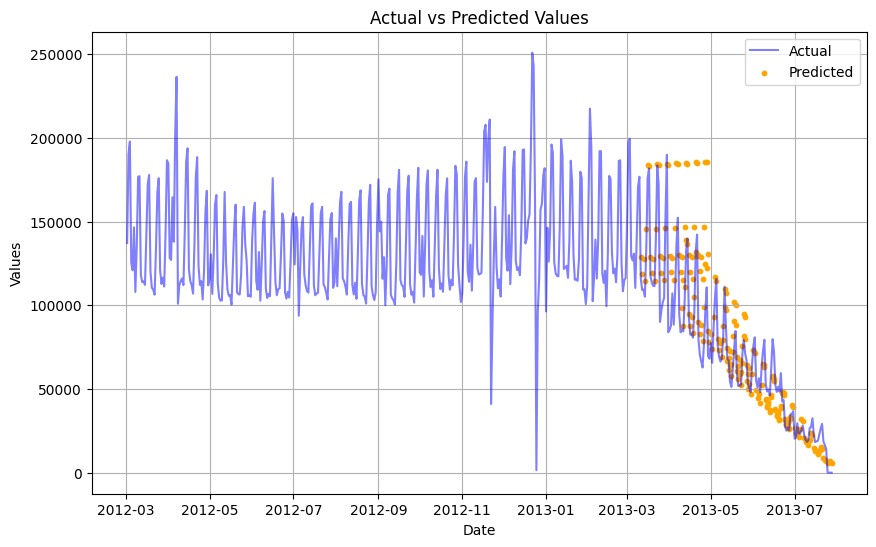

   horizon           mse          rmse           mae       mape     mdape  \
0   5 days  9.412913e+07   9702.016561   8720.971761   0.105017  0.099726   
1   6 days  8.878392e+07   9422.521885   8442.019014   0.107611  0.089611   
2   7 days  1.004550e+08  10022.725011   8500.650736   0.111051  0.088037   
3   8 days  1.044028e+08  10217.770148   8779.635437   0.116150  0.093880   
4   9 days  1.200378e+08  10956.174790   9448.267539   0.128915  0.110441   
5  10 days  1.339783e+08  11574.900737  10083.466250   0.137453  0.123312   
6  11 days  1.235639e+08  11115.928364   9275.633767   0.129184  0.110441   
7  12 days  1.195787e+08  10935.206879   9463.305271   0.132964  0.094668   
8  13 days  1.155000e+08  10747.093753   8877.740000   0.131388  0.089524   
9  14 days  1.059195e+08  10291.719574   8452.057980   0.122569  0.089524   
10 15 days  1.814957e+08  13472.034642   9860.610148   0.141103  0.092972   
11 16 days  2.084079e+08  14436.339798  11083.603068   0.156779  0.125293   

In [54]:
print(f"This is the Automatic model cross validation results: \n")

cross_validation_test(auto_model)

print('-'*60)

print(f"This is the Manual model cross validation results: \n")

cross_validation_test(manual_model)

print('-'*60)

In [40]:
print(auto_model.changepoints)

16    2012-03-18
33    2012-04-04
49    2012-04-20
66    2012-05-07
82    2012-05-23
98    2012-06-08
115   2012-06-25
131   2012-07-11
148   2012-07-28
164   2012-08-13
180   2012-08-29
197   2012-09-15
213   2012-10-01
230   2012-10-18
246   2012-11-03
262   2012-11-19
279   2012-12-06
295   2012-12-22
312   2013-01-08
328   2013-01-24
344   2013-02-09
361   2013-02-26
377   2013-03-14
394   2013-03-31
410   2013-04-16
Name: ds, dtype: datetime64[ns]


11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
11:04:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/4 [00:00<?, ?it/s]11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
11:04:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 1/4 [00:00<00:00,  7.28it/s]11:04:01 - cmdstanpy - INFO - Chain [1] start processing
11:04:01 - cmdstanpy - INFO - Chain [1] done processing
11:04:01 - cmdstanpy - INFO - Chain [1] s

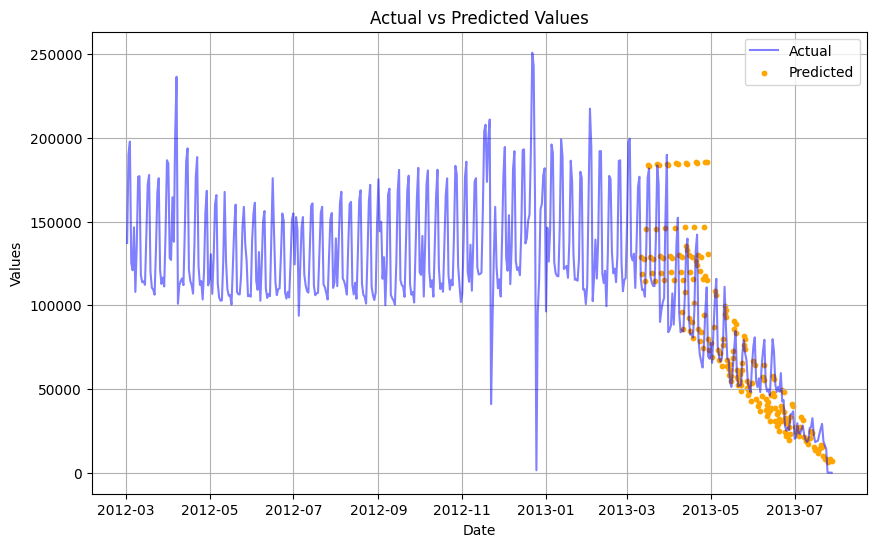

   horizon           mse          rmse           mae       mape     mdape  \
0   5 days  9.507140e+07   9750.456364   8768.933552   0.105905  0.099794   
1   6 days  8.813589e+07   9388.071664   8229.295505   0.104356  0.089611   
2   7 days  9.196459e+07   9589.817252   7912.393836   0.102818  0.077800   
3   8 days  9.408912e+07   9699.954488   8169.944105   0.106501  0.087460   
4   9 days  1.034518e+08  10171.125978   8526.928623   0.113942  0.092121   
5  10 days  1.101382e+08  10494.674118   8503.079827   0.115395  0.091885   
6  11 days  1.041009e+08  10202.985128   8158.817506   0.112351  0.077564   
7  12 days  1.102037e+08  10497.796442   8719.388864   0.119007  0.091885   
8  13 days  1.069019e+08  10339.339751   8092.006666   0.116220  0.051236   
9  14 days  1.016985e+08  10084.569749   8009.479761   0.112956  0.062837   
10 15 days  1.765496e+08  13287.196768   9808.616478   0.136078  0.092778   
11 16 days  1.974679e+08  14052.326675  10664.212839   0.148349  0.124371   

In [76]:
# Selecting the later changepoints form above
manual_model = Prophet(
    growth = 'linear', 
    changepoints = ['2013-03-01', '2013-03-14', '2013-03-31', '2013-04-16'],
    weekly_seasonality = True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=1,
)

manual_model.fit(df)
cross_validation_test(manual_model)